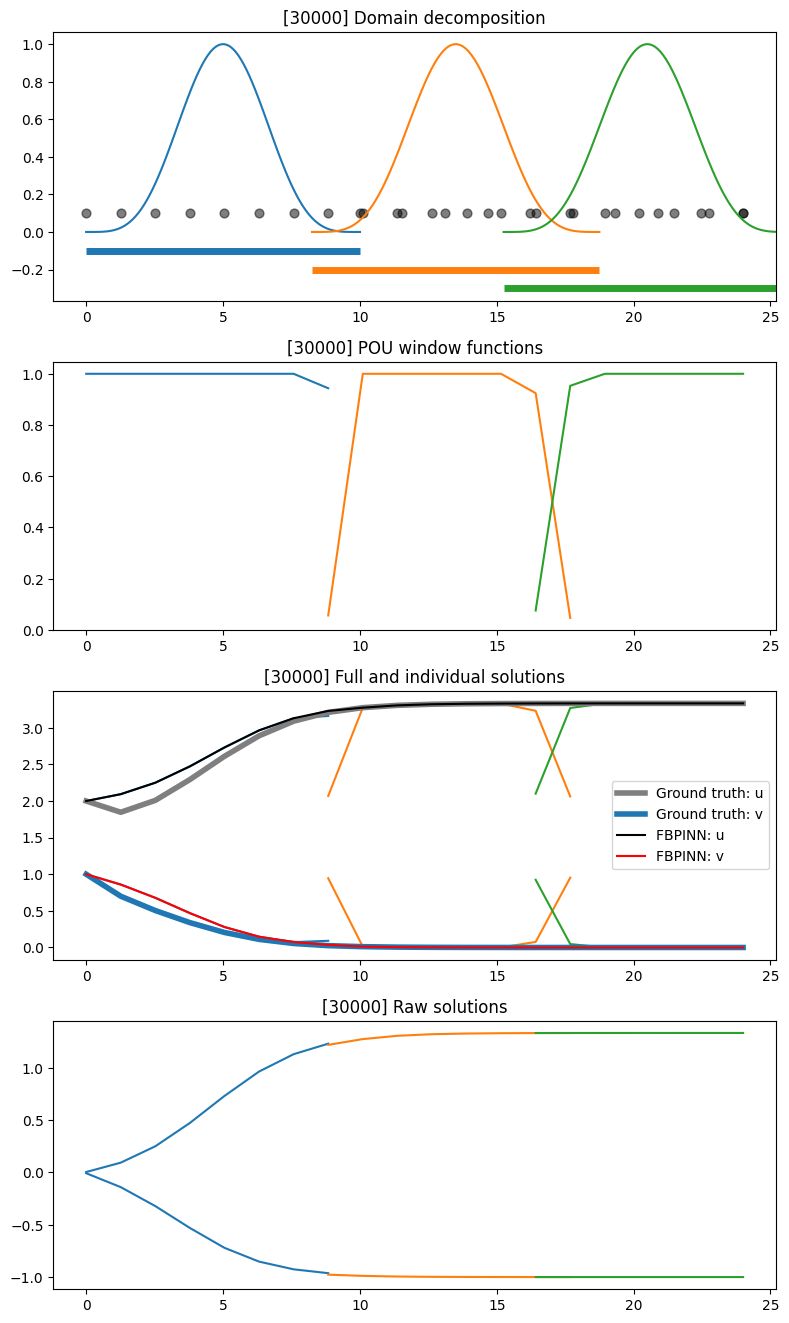

[INFO] 2024-04-01 01:12:50 - [i: 30000/30000] Training complete


In [29]:
import sys
import os

# Paths you want to add to sys.path
paths_to_add = [
    os.path.abspath(os.path.join('../..')),  
    os.path.abspath(os.path.join('..'))  
]

sys.path.extend(path for path in paths_to_add if path not in sys.path)

import numpy as np
from fbpinns.domains import RectangularDomainND

domain = RectangularDomainND
domain_init_kwargs = dict(
    xmin = np.array([0.,]),
    xmax = np.array([24.,])
)

domain_init_kwargs

import jax.numpy as jnp
from fbpinns.problems import Problem

from scipy.integrate import odeint
from scipy.interpolate import interp1d

class CompetitionModel(Problem):

    @staticmethod
    def init_params(params=[0.5, 0.7, 0.3, 0.3, 0.6], u0=2, v0=1, sd=0.1):
        
        r, a1, a2, b1, b2 = params 
        static_params = {
            "dims":(2,1),   # dims of solution and problem
            "r_true":r,
            "a1_true":a1,
            "a2_true":a2,
            "b1_true":b1,
            "b2_true":b2,
            "u0":u0,
            "v0":v0,
            "sd":sd,
        }
        trainable_params = {
            "r":jnp.array(0.),
            "a1":jnp.array(0.),
            "a2":jnp.array(0.),
            "b1":jnp.array(0.),
            "b2":jnp.array(0.),
        }
        return static_params, trainable_params
    
    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        # Physics Loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0, ()),  
            (1, ()),  
            (0, (0,)), 
            (1, (1,)),  
        )

        # Data Loss
        u0 = all_params["static"]["problem"]["u0"]
        v0 = all_params["static"]["problem"]["v0"]
        x_batch_data = jnp.linspace(10, 24, 10).astype(float).reshape((-1,1))
        # r_true, a1_true, a2_true, b1_true, b2_true = [all_params['static']["problem"][key] for key in ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')]
        # params = (r_true, a1_true, a2_true, b1_true, b2_true)
        # solution = odeint(CompetitionModel.model, [u0,v0], x_batch_data.reshape((-1,)), args=(params,))
        solution = CompetitionModel.exact_solution(all_params, x_batch_data)
        u_data = solution[:,0]
        v_data = solution[:,1]
        required_ujs_data = (
            (0, ()), 
            (1, ()),  
        )


        return [[x_batch_phys, required_ujs_phys],
                [x_batch_data, u_data, v_data, required_ujs_data]]
    
    @staticmethod
    def constraining_fn(all_params, x_batch, solution):
        sd = all_params["static"]["problem"]["sd"]
        u0 = all_params["static"]["problem"]["u0"]
        v0 = all_params["static"]["problem"]["v0"]

        x, tanh = x_batch[:,0:1], jnp.tanh

        u = solution[:, 0:1] * tanh(x/sd) + u0 # Hard constraining
        v = solution[:, 1:2] * tanh(x/sd)  + v0

        return jnp.concatenate([u, v], axis=1)
    
    @staticmethod
    def loss_fn(all_params, constraints):
        
        r, a1, a2, b1, b2 = [all_params['trainable']["problem"][key] for key in ('r', 'a1', 'a2', 'b1', 'b2')]

        # Physics loss
        _, u, v, ut, vt = constraints[0]
        phys1 = jnp.mean((ut - u + a1*u**2 + a2*u*v)**2)
        phys2 = jnp.mean((vt - r*v + r*b1*u*v + r*b2*v**2)**2)
        phys = phys1 + phys2

        # Data Loss
        _, ud, vd, u, v = constraints[1]
        u = u.reshape(-1) 
        v = v.reshape(-1) 
        data = 1e6*jnp.mean((u-ud)**2) + 1e6*jnp.mean((v-vd)**2)
        
        return phys + data

    @staticmethod
    def model(y, t, params):
        """
        Compute the derivatives of the system at time t.
        
        :param y: Current state of the system [u, v].
        :param t: Current time.
        :param params: Parameters of the model (a1, a2, b1, b2, r).
        :return: Derivatives [du/dt, dv/dt].
        """
        u, v = y  
        r, a1, a2, b1, b2 = params  
        
        # Define the equations
        du_dt = u * (1 - a1 * u - a2 * v)
        dv_dt = r * v * (1 - b1 * u - b2 * v)
        
        return [du_dt, dv_dt]
    
    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        r, a1, a2, b1, b2 = [all_params['static']["problem"][key] for key in ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')]
        u0 = all_params["static"]["problem"]["u0"]
        v0 = all_params["static"]["problem"]["v0"]
        params = [r, a1, a2, b1, b2]
        
        t = jnp.arange(0, 25.02, 0.02)  
        
        # Solve the system 
        solution = odeint(CompetitionModel.model, [u0, v0], t, args=(params,))
        
        # Interpolation 
        u_interp = interp1d(t, solution[:, 0], kind='cubic')
        v_interp = interp1d(t, solution[:, 1], kind='cubic')
        
        u_data = u_interp(x_batch.flatten())
        v_data = v_interp(x_batch.flatten())
        
        # Combine 
        combined_solution = jnp.vstack((u_data, v_data)).T
        if batch_shape:
            combined_solution = combined_solution.reshape(batch_shape + (2,))
        
        return combined_solution
    
    @staticmethod
    def learned_solution(all_params, x_batch):
        # r_true, a1_true, a2_true, b1_true, b2_true = [all_params['static']["problem"][key] for key in ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')]
        r, a1, a2, b1, b2 = [all_params['trainable']["problem"][key] for key in ('r', 'a1', 'a2', 'b1', 'b2')]
        u0 = all_params["static"]["problem"]["u0"]
        v0 = all_params["static"]["problem"]["v0"]
        params = [r, a1, a2, b1, b2]

        solution = odeint(CompetitionModel.model, [u0, v0], x_batch, args=(params,))

        return solution


# solution = odeint(self._model, initial_conditions, t_span)
# from scipy.integrate import odeint
    
problem = CompetitionModel
# params = [0.5, 0.7, 0.3, 0.3, 0.6]
params = [0.5, 0.3, 0.6, 0.7, 0.3]
problem_init_kwargs = dict(
    params=params, u0=2, v0=1,
)

from fbpinns.decompositions import RectangularDecompositionND
from subdomain_helper import get_subdomain_xsws

decomposition = RectangularDecompositionND
w=1.5
subdomain_xs, subdomain_ws = get_subdomain_xsws([10, 24], 0, 24, 3, w, 1.0005)
decomposition_init_kwargs = dict(
    subdomain_xs = subdomain_xs,
    subdomain_ws = subdomain_ws,
    unnorm = (0., 1.),
)
decomposition_init_kwargs

from fbpinns.networks import FCN

network = FCN# place a fully-connected network in each subdomain
network_init_kwargs=dict(
    layer_sizes=[1,5, 5 ,5,2],# with 2 hidden layers
)

from fbpinns.constants import Constants

c = Constants(
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    ns=((20,),),# use 200 collocation points for training
    n_test=(20,),# use 500 points for testing
    n_steps=30000,# number of training steps
    clear_output=True,
    sampler='grid',
)

from fbpinns.trainers import FBPINNTrainer

run = FBPINNTrainer(c)
all_params = run.train()


In [94]:
from plot import load_FBPINN, load_PINN, exact_solution
from fbpinns.analysis import load_model

out_folder = "test"
c, model = load_model(out_folder, rootdir="results/")

[INFO] 2024-04-01 02:52:42 - Loading model from:
results/models/test/model_00030000.jax


In [95]:
from fbpinns.trainers import _common_train_initialisation
from fbpinns.trainers import FBPINN_loss
from jax import random

i, all_params, active, all_opt_states = model[0], model[1], model[3], model[2]

def get_loss(c, all_params, active, all_opt_states, i):
    key = random.PRNGKey(c.seed)
    domain, problem, decomposition, network = c.domain, c.problem, c.decomposition, c.network
    (_, all_opt_states, _, loss_fn, key, constraints_global, x_batch_global, 
        constraint_offsets_global, constraint_fs_global, 
        jmapss, _, _) = _common_train_initialisation(c, key, all_params, problem, domain)
    
    (active, _, _, 
        active_params, fixed_params, static_params, takess, 
        constraints, _) = run._get_update_inputs(i, active , all_params, all_opt_states ,
                                                        x_batch_global, constraints_global, constraint_fs_global, 
                                                        constraint_offsets_global, decomposition, problem)                          
    # required_ujss = [constraint_[-1] for constraint_ in constraints_global]
    model_fns = (decomposition.norm_fn, network.network_fn, decomposition.unnorm_fn, decomposition.window_fn, problem.constraining_fn)
    lossval = FBPINN_loss(active_params, fixed_params, static_params, takess, constraints, model_fns, jmapss, loss_fn)
    return lossval
    
print(get_loss(c, all_params, active, all_opt_states, i))

[INFO] 2024-04-01 02:52:43 - Total number of trainable parameters:
[INFO] 2024-04-01 02:52:43 - 	network: 246
[INFO] 2024-04-01 02:52:43 - 	problem: 5
[INFO] 2024-04-01 02:52:43 - Total number of constraints: 2
[INFO] 2024-04-01 02:52:43 - Computing exact solution..
[INFO] 2024-04-01 02:52:43 - Computing done
[INFO] 2024-04-01 02:52:43 - [i: 30000/30000] Updating active inputs..
[INFO] 2024-04-01 02:52:43 - [i: 30000/30000] Average number of points/dimension in active subdomains: 12.00
[INFO] 2024-04-01 02:52:43 - [i: 30000/30000] Updating active inputs done (0.05 s)
[INFO] 2024-04-01 02:52:43 - x_batch
[INFO] 2024-04-01 02:52:43 - (20, 1), float32, JVPTracer
[INFO] 2024-04-01 02:52:43 - x_take
[INFO] 2024-04-01 02:52:43 - (23, 1), float32, JVPTracer
[INFO] 2024-04-01 02:52:43 - x_batch
[INFO] 2024-04-01 02:52:43 - (20, 1), float32, JVPTracer
[INFO] 2024-04-01 02:52:43 - x_take
[INFO] 2024-04-01 02:52:43 - (23, 1), float32, JVPTracer
[INFO] 2024-04-01 02:52:43 - x_batch
[INFO] 2024-04-

In [92]:
def _collect_weights(all_params):
    network_params = all_params["trainable"]["network"]["subdomain"]["layers"]
    problem_params = all_params["trainable"]["problem"]
    x_values = []
    for w, b in network_params:
        for subdomain_weights in w:
            flattened_weights = jnp.array(subdomain_weights).flatten()
            x_values.append(jnp.array(flattened_weights))
        for subdomain_biases in b:
            flattened_biases = jnp.array(subdomain_biases).flatten()
            x_values.append(jnp.array(flattened_biases))
    param_values = jnp.array([float(problem_params[key]) for key in problem_params])
    x_values.append(jnp.array(param_values))
    return x_values

x_trained = _collect_weights(all_params)
print(len(x_trained))
for x in x_trained:
    print(x.shape)

25
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(25,)
(25,)
(25,)
(5,)
(5,)
(5,)
(25,)
(25,)
(25,)
(5,)
(5,)
(5,)
(10,)
(10,)
(10,)
(2,)
(2,)
(2,)
(5,)


In [102]:
x_trained

[Array([ 0.6683272 , -0.66191286, -0.63080794, -1.3110255 , -1.0142002 ],      dtype=float32),
 Array([-0.8025392 ,  1.3167613 , -0.3070431 ,  0.15314125,  0.6277404 ],      dtype=float32),
 Array([ 0.02709841,  0.00347373,  0.10883301, -0.15243098,  0.01546161],      dtype=float32),
 Array([ 0.81235224, -0.7840598 ,  0.14642248,  0.15295541, -1.0600281 ],      dtype=float32),
 Array([-0.73430604,  0.28543335, -0.39458376,  0.30157822, -0.8272007 ],      dtype=float32),
 Array([ 1.0931219 , -0.50990987, -1.2239923 ,  0.18414365, -1.1222625 ],      dtype=float32),
 Array([-0.26924887, -0.10481223, -0.06817503,  0.6261789 , -0.22487685,
         0.1153154 , -0.10723411, -0.5448432 , -0.11506542, -0.4684317 ,
         0.2736719 , -0.76432157, -0.1353303 , -0.5058766 ,  0.02364151,
         0.24661103, -0.03639466,  0.12518367, -0.68689984,  0.42402762,
        -0.27271232,  0.3925478 ,  0.02443518,  0.31407896,  0.3904435 ],      dtype=float32),
 Array([-0.30102527, -0.19557385, -0.320359

In [98]:
all_params["trainable"]["problem"]

{'a1': Array(0.30011418, dtype=float32),
 'a2': Array(0.37927255, dtype=float32),
 'b1': Array(-0.3348062, dtype=float32),
 'b2': Array(1.4232924, dtype=float32),
 'r': Array(-0.30237293, dtype=float32)}

In [106]:
from jax import numpy as jnp

from jax import numpy as jnp

def _update_weights(all_params, x_values):
    idx = 0 
    new_network_params = []

    for layer_params in all_params["trainable"]["network"]["subdomain"]["layers"]:
        w, b = layer_params 

        new_w = []
        for subdomain_weights in w:
            weight_count = subdomain_weights.size
            new_weights = jnp.reshape(x_values[idx][:weight_count], subdomain_weights.shape)
            new_w.append(new_weights)
            idx += 1

        new_b = []
        for subdomain_biases in b:
            bias_count = subdomain_biases.size
            new_biases = jnp.reshape(x_values[idx][:bias_count], subdomain_biases.shape)
            new_b.append(new_biases)
            idx += 1

        new_network_params.append((new_w, new_b))
    
    # assign
    all_params["trainable"]["network"]["subdomain"]["layers"] = new_network_params

    # set problem_params
    problem_keys = list(all_params["trainable"]["problem"].keys())
    for i, key in enumerate(problem_keys):
        all_params["trainable"]["problem"][key] = jnp.array(x_trained[idx][i], dtype=jnp.float32)
    
    return all_params

_update_weights(all_params, x_trained)
all_params["trainable"]["problem"] 

{'a1': Array(0.30011418, dtype=float32),
 'a2': Array(0.37927255, dtype=float32),
 'b1': Array(-0.3348062, dtype=float32),
 'b2': Array(1.4232924, dtype=float32),
 'r': Array(-0.30237293, dtype=float32)}

In [83]:
# Initialize

norm = 2
_norm = lambda xs: np.linalg.norm(xs, norm)
c_0, model_0 = load_model(out_folder, i=0, rootdir="results/")
i_0, all_params_0, active_0, all_opt_states_0 = model_0[0], model_0[1], model_0[3], model_0[2]
all_params_0 = model_0[1]
_weight_norm = [_norm(np.concatenate(_collect_weights(all_params_0)))]
print(_weight_norm)
_loss_value  = [get_loss(c_0, all_params_0, active_0, all_opt_states_0, i_0)]
_loss_value

[INFO] 2024-04-01 02:32:51 - Loading model from:
results/models/test/model_00000000.jax
[5.111022]
[INFO] 2024-04-01 02:32:51 - Total number of trainable parameters:
[INFO] 2024-04-01 02:32:51 - 	network: 246
[INFO] 2024-04-01 02:32:51 - 	problem: 5
[INFO] 2024-04-01 02:32:51 - Total number of constraints: 2
[INFO] 2024-04-01 02:32:51 - Computing exact solution..
[INFO] 2024-04-01 02:32:51 - Computing done
[INFO] 2024-04-01 02:32:51 - [i: 0/30000] Updating active inputs..
[INFO] 2024-04-01 02:32:51 - [i: 0/30000] Average number of points/dimension in active subdomains: 12.00
[INFO] 2024-04-01 02:32:51 - [i: 0/30000] Updating active inputs done (0.06 s)
[INFO] 2024-04-01 02:32:51 - x_batch
[INFO] 2024-04-01 02:32:51 - (20, 1), float32, JVPTracer
[INFO] 2024-04-01 02:32:51 - x_take
[INFO] 2024-04-01 02:32:51 - (23, 1), float32, JVPTracer
[INFO] 2024-04-01 02:32:51 - x_batch
[INFO] 2024-04-01 02:32:51 - (20, 1), float32, JVPTracer
[INFO] 2024-04-01 02:32:51 - x_take
[INFO] 2024-04-01 02:3

[Array(2272702.8, dtype=float32)]

In [107]:

def on_epoch_end(epoch, all_params, logs={}):
        # if epoch % self._freq != 0:
        #     return
        x_trained = _collect_weights(all_params)
        _weight_norm.append(_norm(np.concatenate(x_trained)))
        _loss_value.append(get_loss(c, all_params, active, all_opt_states, i))
        logs['norm-loss-weights'] = _weight_norm[-1]
on_epoch_end(500, all_params)

[INFO] 2024-04-01 03:05:12 - Total number of trainable parameters:
[INFO] 2024-04-01 03:05:12 - 	network: 246
[INFO] 2024-04-01 03:05:12 - 	problem: 5
[INFO] 2024-04-01 03:05:12 - Total number of constraints: 2
[INFO] 2024-04-01 03:05:12 - Computing exact solution..
[INFO] 2024-04-01 03:05:12 - Computing done
[INFO] 2024-04-01 03:05:12 - [i: 30000/30000] Updating active inputs..
[INFO] 2024-04-01 03:05:12 - [i: 30000/30000] Average number of points/dimension in active subdomains: 12.00
[INFO] 2024-04-01 03:05:12 - [i: 30000/30000] Updating active inputs done (0.20 s)
[INFO] 2024-04-01 03:05:12 - x_batch
[INFO] 2024-04-01 03:05:12 - (20, 1), float32, JVPTracer
[INFO] 2024-04-01 03:05:12 - x_take
[INFO] 2024-04-01 03:05:12 - (23, 1), float32, JVPTracer


TypeError: dot requires ndarray or scalar arguments, got <class 'list'> at position 0.

In [84]:
norm = 2
_norm = lambda xs: np.linalg.norm(xs, norm)
_weight_norm = [_norm(np.concatenate(_collect_weights(all_params)))]
print(_weight_norm)
# delta_weights = 2.0 * abs(_weight_norm[-1] - _weight_norm[0]) 
delta_weights = 2.0 * abs(_weight_norm[-1] - 5.111022)
delta_weights

[6.5343995]


2.846755018859863

In [68]:
c.run

'test'

In [109]:
from jax import random
norm = 2
_norm = lambda xs: np.linalg.norm(xs, norm)
_resolution = 40
_weight_norm = [_norm(np.concatenate(_collect_weights(all_params)))]

def on_train_end(c, active, all_opt_states, i, all_params, logs={}):
    x_trained = _collect_weights(all_params)
    x_sizes = [x.size for x in x_trained]
    num_param = sum(x_sizes)
    n0 = np.split(np.random.standard_normal(num_param), np.cumsum(x_sizes))
    n1 = np.split(np.random.standard_normal(num_param), np.cumsum(x_sizes))
    
    n0_norm, n1_norm = [_norm(np.concatenate(ni)) for ni in [n0, n1]]
    n0 = [ni/n0_norm for ni in n0]
    n1 = [ni/n1_norm for ni in n1]

    delta_weights = 2.0 * abs(_weight_norm[-1] - _weight_norm[0])
    loss_values = np.zeros((_resolution**2, 3))

    k = 0
    for i, l0 in enumerate(np.linspace(-delta_weights, delta_weights, _resolution)):
        for j, l1 in enumerate(np.linspace(-delta_weights, delta_weights, _resolution)):
            test_weights = [xi + n0i*l0 + n1i*l1 for xi,n0i,n1i in zip(x_trained, n0, n1)]
            _update_weights(all_params, test_weights)
            loss_values[k, :] = [l0, l1, get_loss(c, all_params, active, all_opt_states, i)]
            k += 1
            # save the calculations
            np.savetxt(
                "-landscape.csv",
                loss_values,
                delimiter=','
            )
on_train_end(c, active, all_opt_states, i, all_params, logs={})

[INFO] 2024-04-01 03:06:28 - Total number of trainable parameters:
[INFO] 2024-04-01 03:06:28 - 	network: 246
[INFO] 2024-04-01 03:06:28 - 	problem: 5
[INFO] 2024-04-01 03:06:28 - Total number of constraints: 2
[INFO] 2024-04-01 03:06:28 - Computing exact solution..
[INFO] 2024-04-01 03:06:28 - Computing done
[INFO] 2024-04-01 03:06:28 - [i: 0/30000] Updating active inputs..
[INFO] 2024-04-01 03:06:28 - [i: 0/30000] Average number of points/dimension in active subdomains: 12.00


[INFO] 2024-04-01 03:06:28 - [i: 0/30000] Updating active inputs done (0.07 s)
[INFO] 2024-04-01 03:06:28 - x_batch
[INFO] 2024-04-01 03:06:28 - (20, 1), float32, JVPTracer
[INFO] 2024-04-01 03:06:28 - x_take
[INFO] 2024-04-01 03:06:28 - (23, 1), float32, JVPTracer


TypeError: dot requires ndarray or scalar arguments, got <class 'list'> at position 0.

In [48]:
k = -1
w_list = []
for w in x_trained[7]:
    k +=1
    value = jnp.array(x_trained[k])
    print(value)

[ 0.6683272  -0.66191286 -0.63080794 -1.3110255  -1.0142002 ]
[-0.8025392   1.3167613  -0.3070431   0.15314125  0.6277404 ]
[ 0.02709841  0.00347373  0.10883301 -0.15243098  0.01546161]
[ 0.81235224 -0.7840598   0.14642248  0.15295541 -1.0600281 ]
[-0.73430604  0.28543335 -0.39458376  0.30157822 -0.8272007 ]
[ 1.0931219  -0.50990987 -1.2239923   0.18414365 -1.1222625 ]
[-0.26924887 -0.10481223 -0.06817503  0.6261789  -0.22487685  0.1153154
 -0.10723411 -0.5448432  -0.11506542 -0.4684317   0.2736719  -0.76432157
 -0.1353303  -0.5058766   0.02364151  0.24661103 -0.03639466  0.12518367
 -0.68689984  0.42402762 -0.27271232  0.3925478   0.02443518  0.31407896
  0.3904435 ]
[-0.30102527 -0.19557385 -0.32035947  0.13816732 -0.3493501  -0.19656198
  0.13058092 -0.21060857  0.22560044  0.15311742  0.47149396  0.17150465
  0.5721083  -0.5604478   0.14154862 -0.58265775 -0.16547371 -0.43136257
  0.23121193 -0.26638746  0.5299033   0.18632159  0.14051424 -0.59314764
 -0.26212737]
[ 1.4992876e-01  

In [ ]:
[Array([ 0.6683272 , -0.66191286, -0.63080794, -1.3110255 , -1.0142002 ],      dtype=float32),
 Array([-0.8025392 ,  1.3167613 , -0.3070431 ,  0.15314125,  0.6277404 ],      dtype=float32),
 Array([ 0.02709841,  0.00347373,  0.10883301, -0.15243098,  0.01546161],      dtype=float32),
 Array([ 0.81235224, -0.7840598 ,  0.14642248,  0.15295541, -1.0600281 ],      dtype=float32),
 Array([-0.73430604,  0.28543335, -0.39458376,  0.30157822, -0.8272007 ],      dtype=float32),
 Array([ 1.0931219 , -0.50990987, -1.2239923 ,  0.18414365, -1.1222625 ], 

Test model with a1 and a2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from ipywidgets import interact, FloatSlider


def model(y, t, r, a1, a2, b1, b2):
    u, v = y
    du_dt = u * (1 - a1 * u - a2 * v)
    dv_dt = r * v * (1 - b1 * u - b2 * v)
    return [du_dt, dv_dt]

def plot_model(r, a1, a2, b1, b2):
    params = {'r': r, 'a1': a1, 'a2': a2, 'b1': b1, 'b2': b2} 
    
    # Integrate ODE
    sol = odeint(model, y0, t, args=(params['r'], params['a1'], params['a2'], params['b1'], params['b2']))
    
    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(t, sol[:, 0], label='u(t)')
    plt.plot(t, sol[:, 1], label='v(t)')
    plt.title('Model with a1 = {:.2f}, a2 = {:.2f}, b1 = {:.2f}, b2 = {:.2f}'.format(a1, a2, b1, b2))
    plt.xlabel('Time')
    plt.ylabel('Populations')
    plt.legend()
    plt.grid()
    plt.show()

t = np.linspace(0, 24, 200)
y0 = [2, 1]

# Create sliders
a1_slider = FloatSlider(min=0, max=1, step=0.01, value=0.7, description='a1')
a2_slider = FloatSlider(min=0, max=1, step=0.01, value=0.3, description='a2')
b1_slider = FloatSlider(min=0, max=1, step=0.01, value=0.3, description='b1')
b2_slider = FloatSlider(min=0, max=1, step=0.01, value=0.6, description='b2')
r_slider = FloatSlider(min=0, max=1, step=0.01, value=0.5, description='r')

interact(plot_model,r=r_slider, a1=a1_slider, a2=a2_slider, b1=b1_slider, b2=b2_slider);


interactive(children=(FloatSlider(value=0.5, description='r', max=1.0, step=0.01), FloatSlider(value=0.7, desc…